# Classification with text and audio features
Updates: 
* 03/11 - reorganize the code and rename some variables, 
  change `X` to `x_text`, `X_train` to `x_txt_train`, `X_test` to `x_txt_test`, `Y` to `y_text`
* 03/18 - try NN
  see the 2 code blocks under the section "convert features and labels" if you're trying to get x and y for NN.


In [192]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd

from scipy.sparse import coo_matrix, hstack

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

import pickle

## ref: https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, is_mfcc, is_chroma, is_mel):
    
    X, sample_rate = librosa.load(file_name, sr=None, mono=True)
    
    if is_chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if is_mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if is_chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if is_mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result


#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x = []
    audio_list = sorted(os.listdir(train_dir))
    # gen = (x for x in audio_list)
    
    gen = (u for u in train_df[['Dialogue_ID', 'Utterance_ID']].values)
    for dia_utt in gen:
        dia_id = dia_utt[0]
        utt_id = dia_utt[1]
        file_name = f"dia{dia_id}_utt{utt_id}.wav"
        
        feature=extract_feature(train_dir + file_name, is_mfcc=True, is_chroma=True, is_mel=False)
        x.append(feature)
    
    labels_1d = np.reshape(labels_matrix, max_dia * max_utt)
    labels_1d = labels_1d[~np.equal(labels_1d, 99)]
    y = list(labels_1d)
    
    return x, y

# for file_name in gen:
#     # file_name=os.path.basename(file) ## in the form of dia*_utt*.wav
#     print(file_name)
#     ## get ids for dialogue 
#     temp = file_name.split("_")
#     dia_id = int(temp[0][3:])
#     utt_id = int(temp[1].split(".")[0][3:])

#     # emotion=labels_matrix[dia_id, utt_id]
#     # if emotion not in emotions:
#     #     continue
#     feature=extract_feature(train_dir + file_name, is_mfcc=True, is_chroma=True, is_mel=True)
#     x_matrix[dia_id, utt_id] = feature

In [2]:
max_dia = 1039
max_utt = 24
is_reload = False ## please set it to False if you are using features saved in pickle file 
test_size = 0.25
total = 9988

## Extract audio features

In [3]:
train_dir = "../data/train/"
emotions = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']
emo2int = dict(zip(emotions, range(len(emotions))))
emo2int['empty'] = 99

train_df = pd.read_csv("../data/train_sent_emo.csv")
## dia125_utt_3 not working
remove_index = train_df[(train_df['Dialogue_ID'] == 125) & (train_df['Utterance_ID'] == 3)].index
train_df = train_df.drop(index=remove_index)

label_pivot = pd.pivot(data=train_df, columns="Utterance_ID", index="Dialogue_ID", values="Emotion").fillna("empty")
label_pivot.loc[60] = ["empty"] * label_pivot.shape[1] ## for some reasons, there is no dialogue 60.
label_pivot = label_pivot.sort_index()
label_pivot = label_pivot.applymap(lambda x: emo2int[x])
labels_matrix = label_pivot.values

In [4]:
train_df.iloc[1163:1166]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
1163,1225,"Hey, if mommy can have a wife, daddy can have ...",Ross,neutral,neutral,125,1,4,18,"00:02:35,613","00:02:38,323"
1164,1226,"Ohh, its time to go.",Emily,neutral,neutral,125,2,4,18,"00:02:40,869","00:02:42,119"
1166,1228,"Huh, what can we do in 17 minutes?",Ross,neutral,neutral,125,4,4,18,"00:02:48,209","00:02:51,295"


In [195]:
#DataFlair - Split the dataset
is_reload = True
if is_reload:
    x_audio, y = load_data(test_size=test_size)
    with open("../data/train_audio_nomel.pickle", 'wb') as pickle_out:
        pickle.dump(x_audio, pickle_out)
    with open("../data/train_labels_nomel.pickle", 'wb') as pickle_out:
        pickle.dump(y, pickle_out)
else:
    with open("../data/train_audio.pickle", 'rb') as pickle_in:
        x_audio = pickle.load(pickle_in)
    with open("../data/train_labels.pickle", 'rb') as pickle_in:
        y = pickle.load(pickle_in)
## x_audio was named as x before

## Try some classifiers

In [6]:
## Multi-layer Perceptron with only audio
x_au_train,x_test,y_train,y_test = train_test_split(np.array(x_audio), y, test_size=test_size, random_state=9)
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model.fit(x_au_train,y_train)
y_pred=model.predict(x_test)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.79      0.60      1152
           1       0.16      0.04      0.06       308
           2       0.18      0.03      0.05        62
           3       0.15      0.08      0.10       185
           4       0.21      0.15      0.17       439
           5       0.01      0.02      0.01        64
           6       0.29      0.08      0.12       287

    accuracy                           0.41      2497
   macro avg       0.21      0.17      0.16      2497
weighted avg       0.33      0.41      0.34      2497



In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.25      0.08      0.12       257
     disgust       0.00      0.00      0.00        65
        fear       0.17      0.01      0.03        71
         joy       0.23      0.22      0.23       441
     neutral       0.51      0.81      0.62      1189
     sadness       0.18      0.01      0.02       167
    surprise       0.22      0.06      0.09       307

    accuracy                           0.44      2497
   macro avg       0.22      0.17      0.16      2497
weighted avg       0.35      0.44      0.36      2497



## Extract text features 
(code from EmotionBaseline.ipynb)

In [6]:
def cleaning(element):
    final_list = []
    """ Clean up text. Tokenize, lowercase, and remove punctuation and stopwords """
    #print("Running cleaner")
    # Remove punctuation, symbols (#) and stopwords
    element = str(element).lower()
    new_string = ''
    for char in element:
        if char not in punctuation_list:
            new_string += char
    all_wrds = new_string.split(" ")
    for word in all_wrds:
        if word not in stop_words_list:
            final_list.append(word)
    final_string = ' '.join(final_list)
    return final_string

def tokenize(str_arg):
    words = str_arg.split()
    return words

In [78]:
# !python -m spacy download en

In [7]:
import spacy
import string

nlp = spacy.load('en')
stop_words_list = list(spacy.lang.en.STOP_WORDS)
punctuation_list = list(string.punctuation)
punctuation_list.extend('\r')
punctuation_list.extend('\n')
punctuation_list.extend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [8]:
train_df['cleaned_Utterance'] = train_df['Utterance'].apply(cleaning)
train_df['tokens'] = train_df['cleaned_Utterance'].apply(tokenize)

train_df.index = range(total)
train_df.iloc[1163:1166]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,cleaned_Utterance,tokens
1163,1225,"Hey, if mommy can have a wife, daddy can have ...",Ross,neutral,neutral,125,1,4,18,"00:02:35,613","00:02:38,323",hey mommy wife daddy bra,"[hey, mommy, wife, daddy, bra]"
1164,1226,"Ohh, its time to go.",Emily,neutral,neutral,125,2,4,18,"00:02:40,869","00:02:42,119",ohh its time,"[ohh, its, time]"
1165,1228,"Huh, what can we do in 17 minutes?",Ross,neutral,neutral,125,4,4,18,"00:02:48,209","00:02:51,295",huh minutes,"[huh, minutes]"


In [9]:
cleaned_utt = np.reshape(train_df['cleaned_Utterance'].values, (total,1))

In [10]:
y[-10:]

[1, 0, 0, 5, 5, 0, 0, 1, 0, 4]

In [11]:
train_df['Emotion'][-10:]

9978    surprise
9979     neutral
9980     neutral
9981     disgust
9982     disgust
9983     neutral
9984     neutral
9985    surprise
9986     neutral
9987         joy
Name: Emotion, dtype: object

In [10]:
x_text = train_df['cleaned_Utterance'] # it was named as X
y_text = train_df['Emotion'] # was named as Y
x_txt_train, x_txt_test, y_txt_train, y_txt_test = train_test_split(x_text, y_text, test_size = test_size, random_state = 42)

In [11]:
## IMPORTANT there's no index 1165 before, run this to chech if you fixed the indices
[i for i in range(total + 1) if i not in y_text.index]

[9988]

In [196]:
# train_index = [i if i < 1165 else i - 1 for i in x_txt_train.index ]
# aud_train = np.array(x)[train_index]
# test_index = [i if i < 1165 else i - 1 for i in x_txt_test.index ]
# aud_test = np.array(x)[test_index]

aud_train = np.array(x_audio)[x_txt_train.index]
aud_test = np.array(x_audio)[x_txt_test.index]


In [36]:
## check whether they are aligned
train_df.loc[x_txt_train.index[:10]]['Emotion']

2022     neutral
9873         joy
2542    surprise
2034        fear
2732        fear
8653     neutral
7349    surprise
1219     neutral
6292     neutral
4149         joy
Name: Emotion, dtype: object

In [38]:
y_txt_train[:10]

2022     neutral
9873         joy
2542    surprise
2034        fear
2732        fear
8653     neutral
7349    surprise
1219     neutral
6292     neutral
4149         joy
Name: Emotion, dtype: object

In [40]:
train_df.loc[x_text[1160:1170].index]['Emotion']

1160     neutral
1161         joy
1162         joy
1163     neutral
1164     neutral
1165     neutral
1166     neutral
1167     neutral
1168     neutral
1169    surprise
Name: Emotion, dtype: object

In [43]:
y_text[1160:1170]

1160     neutral
1161         joy
1162         joy
1163     neutral
1164     neutral
1165     neutral
1166     neutral
1167     neutral
1168     neutral
1169    surprise
Name: Emotion, dtype: object

In [87]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)

In [13]:
count_vect = CountVectorizer()
x_txt_train_counts = count_vect.fit_transform(x_txt_train)
x_txt_test_counts = count_vect.transform(x_txt_test)

In [16]:
x_txt_train_counts.shape

(7491, 4657)

In [17]:
aud_train.shape

(7491, 180)

In [22]:
x_txt_train_counts[0, :10]

<1x10 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [197]:
x_mix_train = hstack((x_txt_train_counts, aud_train))
x_mix_test = hstack((x_txt_test_counts, aud_test))


In [52]:
log_clf_wgt = LogisticRegression(class_weight='balanced').fit(x_mix_train, y_txt_train)

y_log_pred = log_clf_wgt.predict(x_mix_test)
accuracy = accuracy_score(np.array(y_txt_test), y_log_pred)
# Combined report with all above metrics
print(classification_report(y_txt_test, y_log_pred))

              precision    recall  f1-score   support

       anger       0.24      0.29      0.26       312
     disgust       0.06      0.35      0.10        65
        fear       0.02      0.12      0.04        57
         joy       0.24      0.17      0.20       422
     neutral       0.58      0.22      0.32      1152
     sadness       0.11      0.28      0.15       160
    surprise       0.21      0.17      0.19       329

    accuracy                           0.22      2497
   macro avg       0.21      0.23      0.18      2497
weighted avg       0.37      0.22      0.25      2497



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Logistic with Grid Search

In [71]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'C' : [0.5, 0.8, 0.9, 1, 1.2, 1.5, 2, 5],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
log_clf = GridSearchCV(logit, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

# Fit on data
grid_cv =log_clf.fit(x_mix_train, y_txt_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 51.6min finished


In [81]:
results = pd.DataFrame(grid_cv.cv_results_).sort_values(['rank_test_score'])
results.head(6)
# best score may lie between C=[0.1, 10], l1 or l2, need deeper search
best_wgt_params = results[results['param_class_weight'] == "balanced"].head(1)['params'].values[0]
best_wgt_params

{'C': 0.8, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

In [190]:
best_wgt_params = {'C': 0.8, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
base_logit_wgt = LogisticRegression(random_state=1, **best_wgt_params)
base_logit_wgt.fit(x_txt_train_counts, y_txt_train)
base_logit_wgt_pred = base_logit_wgt.predict(x_txt_test_counts)
print(classification_report(y_txt_test, base_logit_wgt_pred))

              precision    recall  f1-score   support

       anger       0.26      0.20      0.22       312
     disgust       0.14      0.18      0.16        65
        fear       0.08      0.14      0.10        57
         joy       0.39      0.35      0.37       422
     neutral       0.57      0.63      0.60      1152
     sadness       0.18      0.18      0.18       160
    surprise       0.42      0.35      0.38       329

    accuracy                           0.44      2497
   macro avg       0.29      0.29      0.29      2497
weighted avg       0.43      0.44      0.43      2497



In [198]:
best_logit_wgt = LogisticRegression(random_state=1, **best_wgt_params)
best_logit_wgt.fit(x_mix_train, y_txt_train)
best_logit_wgt_pred = best_logit_wgt.predict(x_mix_test)
print(classification_report(y_txt_test, best_logit_wgt_pred))

              precision    recall  f1-score   support

       anger       0.27      0.27      0.27       312
     disgust       0.11      0.15      0.13        65
        fear       0.08      0.16      0.11        57
         joy       0.42      0.33      0.37       422
     neutral       0.61      0.63      0.62      1152
     sadness       0.21      0.21      0.21       160
    surprise       0.39      0.37      0.38       329

    accuracy                           0.45      2497
   macro avg       0.30      0.30      0.30      2497
weighted avg       0.46      0.45      0.45      2497



In [86]:
best_logit = LogisticRegression(random_state=1, **grid_cv.best_params_)
best_logit.fit(x_mix_train, y_txt_train)
best_logit_unwgt = best_logit.predict(x_mix_test)
best_logit

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
print(classification_report(y_txt_test, best_logit_unwgt))

              precision    recall  f1-score   support

       anger       0.37      0.14      0.20       312
     disgust       0.50      0.02      0.03        65
        fear       0.17      0.02      0.03        57
         joy       0.46      0.21      0.29       422
     neutral       0.52      0.92      0.66      1152
     sadness       0.32      0.07      0.12       160
    surprise       0.65      0.19      0.29       329

    accuracy                           0.51      2497
   macro avg       0.43      0.22      0.23      2497
weighted avg       0.49      0.51      0.43      2497



In [85]:
best_logit_wgt

array(['neutral', 'neutral', 'neutral', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [77]:
print(classification_report(y_txt_test, best_logit_unwgt))

              precision    recall  f1-score   support

       anger       0.37      0.14      0.20       312
     disgust       0.50      0.02      0.03        65
        fear       0.17      0.02      0.03        57
         joy       0.46      0.21      0.29       422
     neutral       0.52      0.92      0.66      1152
     sadness       0.32      0.07      0.12       160
    surprise       0.65      0.19      0.29       329

    accuracy                           0.51      2497
   macro avg       0.43      0.22      0.23      2497
weighted avg       0.49      0.51      0.43      2497



In [68]:
print(classification_report(y_txt_test, best_logit_unwgt))

              precision    recall  f1-score   support

       anger       0.39      0.18      0.25       312
     disgust       0.20      0.02      0.03        65
        fear       0.18      0.04      0.06        57
         joy       0.43      0.23      0.30       422
     neutral       0.53      0.89      0.66      1152
     sadness       0.29      0.09      0.13       160
    surprise       0.53      0.22      0.32       329

    accuracy                           0.51      2497
   macro avg       0.36      0.24      0.25      2497
weighted avg       0.46      0.51      0.44      2497



In [99]:
model2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model2.fit(x_txt_train_mix, Y_train)
y_pred=model2.predict(x_txt_test_mix)


              precision    recall  f1-score   support

           0       0.63      0.33      0.43       453
           1       0.30      0.54      0.38       133
           2       0.07      0.24      0.11        21
           3       0.17      0.20      0.19        71
           4       0.39      0.40      0.40       177
           5       0.07      0.16      0.10        25
           6       0.20      0.23      0.22       119

    accuracy                           0.34       999
   macro avg       0.26      0.30      0.26       999
weighted avg       0.43      0.34      0.36       999



In [100]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.45      0.49       453
           1       0.32      0.37      0.34       133
           2       0.04      0.05      0.04        21
           3       0.14      0.07      0.09        71
           4       0.25      0.45      0.32       177
           5       0.08      0.04      0.05        25
           6       0.18      0.13      0.15       119

    accuracy                           0.35       999
   macro avg       0.22      0.22      0.21       999
weighted avg       0.37      0.35      0.35       999



In [101]:
## using logistic on only audio data
log_clf_wgt2 = LogisticRegression(class_weight='balanced').fit(x_train, y_train)
y_pred_log2 = log_clf_wgt2.predict(x_test)
print(classification_report(y_test, y_pred_log2))

              precision    recall  f1-score   support

           0       0.55      0.20      0.29      1152
           1       0.13      0.12      0.12       308
           2       0.04      0.18      0.07        62
           3       0.11      0.25      0.15       185
           4       0.26      0.20      0.23       439
           5       0.04      0.27      0.07        64
           6       0.24      0.31      0.27       287

    accuracy                           0.21      2497
   macro avg       0.20      0.22      0.17      2497
weighted avg       0.35      0.21      0.24      2497



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
sample_rate = 44100
this_audio = train_dir + "dia39_utt16.wav"
X, sr = librosa.load(this_audio, sr=None, mono=True)

In [27]:
stft=np.abs(librosa.stft(X))
stft.shape

(1025, 833)

In [28]:
result=np.array([])
mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T, axis=0)
result=np.hstack((result, mfccs))

## Emotion classification using a Simple NN

In [15]:
from keras import models, layers

Using TensorFlow backend.


### convert features and lables

In [23]:
def convert_y(y_labels, num_class=2):
    """convert a list of labels to one-hot encoding for neural network"""
    if num_class > 2:
        encodings = np.zeros((len(y_labels), num_class))
    else:
        raise ValueError("Number of class should be greater than 2, num_class =", num_class)
    for i, this_y in enumerate(y_labels):
        encodings[i, this_y] = 1
    return encodings

In [207]:
x_arr_train = x_mix_train.toarray()
x_arr_test = x_mix_test.toarray()

y_num_train = np.array(y)[y_txt_train.index]
y_num_test = np.array(y)[y_txt_test.index]
y_1hot_train = convert_y(y_num_train, 7)
y_1hot_test = convert_y(y_num_test, 7)

input_shape = x_mix_train.shape[1]

In [70]:
simple_nn = models.Sequential()
simple_nn.add(layers.Dense(32, activation='relu', input_shape=(input_shape, )))
simple_nn.add(layers.Dense(16, activation='relu'))
simple_nn.add(layers.Dense(7, activation='softmax'))
simple_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
simple_nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                154816    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 119       
Total params: 155,463
Trainable params: 155,463
Non-trainable params: 0
_________________________________________________________________


In [36]:
x_mix_test.toarray()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74471360e-09, 1.72682491e-09, 1.69412095e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46812584e-07, 3.42379650e-07, 3.40634188e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.26655038e-07, 1.24367318e-07, 1.23367855e-07],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.23652277e-09, 5.20029309e-09, 5.06713382e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.38951861e-09, 1.39165923e-09, 1.40881651e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.01268953e-08, 7.71062858e-08, 7.68958301e-08]])

In [58]:
history = simple_nn.fit(x_arr_train, y_1hot_train, epochs=25, batch_size=128, verbose=0)
y_nn_predict = simple_nn.predict(x_arr_test)

Epoch 1/25
7491/7491 [==============================] - 1s 159us/step - loss: 0.6053 - accuracy: 0.7975
Epoch 2/25
7491/7491 [==============================] - 1s 114us/step - loss: 0.5869 - accuracy: 0.8023
Epoch 3/25
7491/7491 [==============================] - 1s 119us/step - loss: 0.5911 - accuracy: 0.7992
Epoch 4/25
7491/7491 [==============================] - 1s 119us/step - loss: 0.6449 - accuracy: 0.7817
Epoch 5/25
7491/7491 [==============================] - 1s 114us/step - loss: 0.6033 - accuracy: 0.7915
Epoch 6/25
7491/7491 [==============================] - 1s 119us/step - loss: 0.5929 - accuracy: 0.8034
Epoch 7/25
7491/7491 [==============================] - 1s 132us/step - loss: 0.5959 - accuracy: 0.7987
Epoch 8/25
7491/7491 [==============================] - 1s 116us/step - loss: 0.5811 - accuracy: 0.8024
Epoch 9/25
7491/7491 [==============================] - 1s 132us/step - loss: 0.5764 - accuracy: 0.8035
Epoch 10/25
7491/7491 [==============================] - 1s 132u

In [65]:
int2emo = {v: k for k,v in emo2int.items()}

In [68]:
print(classification_report(np.argmax(y_1hot_test, axis=1), np.argmax(y_nn_predict, axis=1), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.56      0.63      0.59      1152
    surprise       0.39      0.22      0.28       329
        fear       0.06      0.04      0.05        57
     sadness       0.14      0.11      0.12       160
         joy       0.32      0.41      0.36       422
     disgust       0.11      0.11      0.11        65
       anger       0.29      0.24      0.26       312

    accuracy                           0.43      2497
   macro avg       0.27      0.25      0.25      2497
weighted avg       0.41      0.43      0.42      2497



In [62]:
np.argmax(y_1hot_test, axis=1)

array([3, 0, 3, ..., 4, 3, 0])

In [61]:
np.argmax(y_nn_predict, axis=1)

array([0, 4, 0, ..., 4, 0, 4])

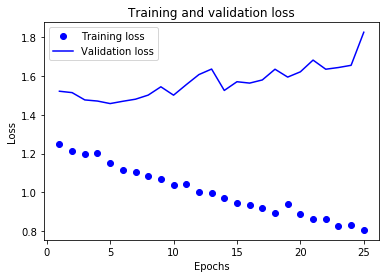

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [53]:
epochs

range(1, 26)

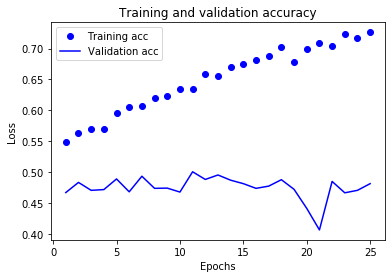

In [54]:
plt.clf()   # clear figure
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## MLP with regularization

In [88]:
from keras.constraints import unit_norm, min_max_norm
from keras.callbacks import EarlyStopping

In [209]:
nn_model2 = models.Sequential()
nn_model2.add(layers.Dense(32, activation='tanh', input_shape=(input_shape, ), kernel_constraint=min_max_norm(-3, 3), bias_constraint=unit_norm()))
nn_model2.add(layers.Dropout(0.2))
nn_model2.add(layers.Dense(16, activation='tanh'))
nn_model2.add(layers.Dropout(0.2))
nn_model2.add(layers.Dense(7, activation='softmax'))
nn_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [213]:
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1)

history2 = nn_model2.fit(x_arr_train, y_1hot_train, epochs=15, batch_size=128, validation_split=0.15, verbose=0, callbacks=[es]) #


Epoch 00002: early stopping


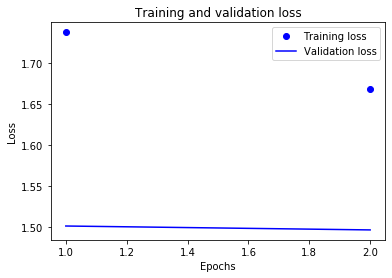

In [211]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

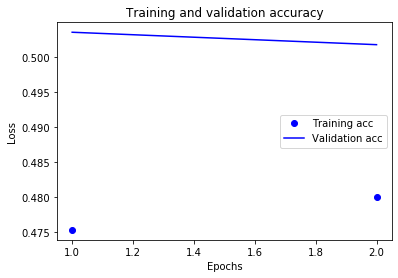

In [141]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [214]:
y_nn_predict2 = nn_model2.predict(x_arr_test)
print(classification_report(np.argmax(y_1hot_test, axis=1), np.argmax(y_nn_predict2, axis=1), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.46      1.00      0.63      1152
    surprise       0.00      0.00      0.00       329
        fear       0.00      0.00      0.00        57
     sadness       0.00      0.00      0.00       160
         joy       0.00      0.00      0.00       422
     disgust       0.00      0.00      0.00        65
       anger       0.00      0.00      0.00       312

    accuracy                           0.46      2497
   macro avg       0.07      0.14      0.09      2497
weighted avg       0.21      0.46      0.29      2497



## Sentiment

In [145]:
sentiments = ['negative', 'neutral', 'positive']
sent2int = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
int2sent = {v: k for k, v in sent2int.items()}

In [146]:
int2sent

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [149]:
train_df['sentiment_int'] = train_df['Sentiment'].apply(lambda x: sent2int[x])

In [153]:
train_df['sentiment_int'].values[y_txt_train.index]

array([1, 2, 0, ..., 1, 0, 0])

In [152]:
y_txt_train

2022     neutral
9873         joy
2542    surprise
2034        fear
2732        fear
          ...   
5734         joy
5191     neutral
5390     neutral
860        anger
7270       anger
Name: Emotion, Length: 7491, dtype: object

In [154]:
y_sent_train = train_df['sentiment_int'].values[y_txt_train.index]
y_sent_test = train_df['sentiment_int'].values[y_txt_test.index]

In [158]:
np.unique(y_sent_train)

array([0, 1, 2])

In [178]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': ['balanced'], # , None
    'C' : [0.1, 0.5, 0.7, 1, 7, 10, 15, 20],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
grid_cv_sent = GridSearchCV(logit, param_grid = param_grid, cv = 4, verbose=2, n_jobs=-1).fit(x_mix_train, y_sent_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 10.1min finished


In [179]:
results = pd.DataFrame(grid_cv_sent.cv_results_).sort_values(['rank_test_score'])
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,13.429574,3.716243,0.008193,0.003015,0.5,balanced,l1,liblinear,"{'C': 0.5, 'class_weight': 'balanced', 'penalt...",0.510411,0.531767,0.556327,0.532585,0.532773,0.016247,1
6,23.079005,2.335466,0.011178,0.004238,1,balanced,l1,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.514148,0.532301,0.560064,0.519765,0.531570,0.017715,2
4,16.339657,1.398755,0.005232,0.001057,0.7,balanced,l1,liblinear,"{'C': 0.7, 'class_weight': 'balanced', 'penalt...",0.514682,0.532835,0.557928,0.518697,0.531036,0.016927,3
11,50.828467,1.226927,0.004471,0.000415,10,balanced,l2,liblinear,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.515216,0.533369,0.556327,0.518697,0.530902,0.016183,4
7,51.828973,1.984817,0.004736,0.000383,1,balanced,l2,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.515216,0.531767,0.553657,0.521368,0.530502,0.014619,5
13,47.941090,2.707076,0.004719,0.000448,15,balanced,l2,liblinear,"{'C': 15, 'class_weight': 'balanced', 'penalty...",0.516284,0.535505,0.554191,0.516026,0.530501,0.015795,6
9,54.444333,3.042131,0.005599,0.001048,7,balanced,l2,liblinear,"{'C': 7, 'class_weight': 'balanced', 'penalty'...",0.515750,0.528564,0.556327,0.517094,0.529434,0.016306,7
1,20.624824,1.828291,0.004367,0.000168,0.1,balanced,l2,liblinear,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",0.507208,0.524826,0.553123,0.532051,0.529302,0.016456,8
3,44.650046,3.442787,0.004812,0.000486,0.5,balanced,l2,liblinear,"{'C': 0.5, 'class_weight': 'balanced', 'penalt...",0.510411,0.532301,0.557395,0.514957,0.528766,0.018437,9
5,49.786807,4.478527,0.015125,0.006583,0.7,balanced,l2,liblinear,"{'C': 0.7, 'class_weight': 'balanced', 'penalt...",0.513615,0.532301,0.552589,0.515491,0.528499,0.015697,10


In [180]:
# best score may lie between C=[0.1, 10], l1 or l2, need deeper search
best_sent_wgt_params = results[results['param_class_weight'] == "balanced"].head(1)['params'].values[0]
best_sent_wgt_params

{'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

In [199]:
best_sent_logit_wgt = LogisticRegression(random_state=1, **best_sent_wgt_params)
best_sent_logit_wgt.fit(x_mix_train, y_sent_train)
best_sent_wgt_pred = best_sent_logit_wgt.predict(x_mix_test)


In [200]:
print(classification_report(y_sent_test, best_sent_wgt_pred, target_names=sentiments))

              precision    recall  f1-score   support

    negative       0.52      0.48      0.50       779
     neutral       0.60      0.71      0.65      1152
    positive       0.46      0.33      0.39       566

    accuracy                           0.55      2497
   macro avg       0.53      0.51      0.51      2497
weighted avg       0.54      0.55      0.54      2497



### unweighted

In [173]:
# best score may lie between C=[0.1, 10], l1 or l2, need deeper search
best_sent_unwgt_params = results.head(1)['params'].values[0]
best_sent_unwgt_params

{'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

In [174]:
best_sent_logit_unwgt = LogisticRegression(random_state=1, **best_sent_unwgt_params)
best_sent_logit_unwgt.fit(x_mix_train, y_sent_train)
best_sent_unwgt_pred = best_sent_logit_unwgt.predict(x_mix_test)

In [177]:
print(classification_report(y_sent_test, best_sent_unwgt_pred, target_names=sentiments))

              precision    recall  f1-score   support

    negative       0.55      0.36      0.44       779
     neutral       0.55      0.84      0.66      1152
    positive       0.51      0.22      0.31       566

    accuracy                           0.55      2497
   macro avg       0.54      0.47      0.47      2497
weighted avg       0.54      0.55      0.51      2497



## Try to solve the problem of always predicting the neurtral class

Changing learning rate helps
Added more layers

In [261]:
from keras.layers import Dense, Dropout
from keras.initializers import RandomUniform
from keras.optimizers import Adam

In [262]:
nn_model3 = models.Sequential()
nn_model3.add(Dense(64, activation='tanh', input_shape=(input_shape, ), kernel_constraint=min_max_norm(-3, 3), bias_constraint=unit_norm(),\
                    kernel_initializer=RandomUniform(minval=-0.1, maxval=+0.1)))
nn_model3.add(Dense(32, activation='tanh', kernel_constraint=min_max_norm(-2, 2), bias_constraint=unit_norm()))
nn_model3.add(Dense(16, activation='tanh'))
nn_model3.add(Dropout(0.2))
nn_model3.add(Dense(16, activation='tanh', kernel_constraint=min_max_norm(-3, 3), bias_constraint=unit_norm()))
nn_model3.add(Dropout(0.2))
nn_model3.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.00001)
nn_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [263]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history2 = nn_model3.fit(x_arr_train, y_1hot_train, epochs=15, batch_size=128, validation_split=0.2, verbose=0, callbacks=[es]) 


# history2 = nn_model3.fit(x_arr_train, y_1hot_train, epochs=15, batch_size=128, validation_split=0.2, verbose=0) #, callbacks=[es]


Epoch 00005: early stopping


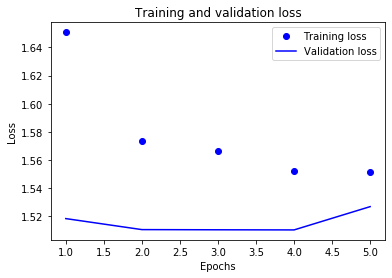

In [264]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

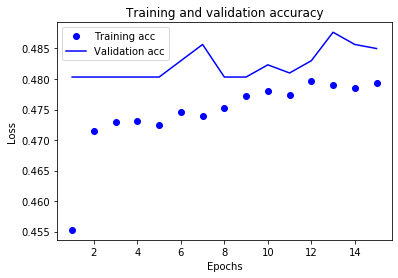

In [257]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [265]:
y_nn_predict3 = nn_model3.predict(x_arr_test)
print(classification_report(np.argmax(y_1hot_test, axis=1), np.argmax(y_nn_predict3, axis=1), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.47      0.99      0.63      1152
    surprise       0.00      0.00      0.00       329
        fear       0.00      0.00      0.00        57
     sadness       0.00      0.00      0.00       160
         joy       0.00      0.00      0.00       422
     disgust       0.00      0.00      0.00        65
       anger       0.35      0.06      0.10       312

    accuracy                           0.46      2497
   macro avg       0.12      0.15      0.10      2497
weighted avg       0.26      0.46      0.30      2497



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
